### Utilies for fetching, transforming and viewing GRTS cell geometries

In many NABat related data management and processing workflows it is useful to have easy tools for working with 
the geometries of NABat GRTS cells.  Commonly used functions and data access routines can be found in nabatpy's grts_lookup module.

#### These include
* Get the bounds (w, s, e, n) of an individual GRTS cell.
* Get a shapely geometry of a GRTS cell for geospatial manipulation/viewing
* Check if a point(x,y) is contained in a GRTS ID
* Transform (reproject) a GRTS geometry to another projections (WGS84, Albers, UTM, etc.)



##### Import our spatial utilies module

In [1]:
import sys
sys.path.append('..')

from nabatpy import grts_lookup

## Get the bounds of an individual GRTS cell.

by default these coordinates are returned in a WGS84 projection

In [2]:
w, s, e, n = grts_lookup.get_grts_geometry(grts_id=55478, sample_frame='Conus', return_type='bounds')
print(w, s, e, n)

-118.61424140897152 37.45133490849996 -118.53011714761556 37.55905466466322


### If you want to do simple geometric manipulations, like calculating area or centroid, you might want these coordinates in the 'native' projection of the sample frame (Alber's equal area)

In [3]:
w, s, e, n = grts_lookup.get_grts_geometry(grts_id=55478, sample_frame='Conus', return_type='bounds', return_proj=None)
print(w, s, e, n)

-1963000 1836000 -1953000 1846000


### If you need a projection that's not WGS84 or the native Albers Equal Area, you can pass any pyproj object to the return_proj parameter

In [4]:
from pyproj import Proj

epsg_utm_13n = '26913'
utm_13n = Proj(f"+init=EPSG:{epsg_utm_13n}")

w, s, e, n = grts_lookup.get_grts_geometry(grts_id=55478, sample_frame='Conus', return_type='bounds', return_proj=utm_13n)
print(w, s, e, n)

-707056.8016685701 4233092.24589123 -697800.0447009779 4244026.458539516


### Check if a point is contained in a cell

In [5]:
wgs_centroid = grts_lookup.get_grts_geometry(grts_id=55478, return_proj='wgs84').centroid

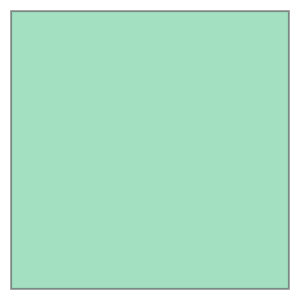

In [6]:
geom = grts_lookup.get_grts_geometry(grts_id=55478, return_proj=None)
geom

In [7]:
from shapely.geometry import Point

wgs_centroid = grts_lookup.get_grts_geometry(grts_id=55478, return_proj='wgs84').centroid
long, lat = wgs_centroid.x, wgs_centroid.y

x, y = grts_lookup.WGS_to_framecoords(long=long, lat=lat)

point = Point(x, y)

geom.contains(point)

True

In [8]:
point = point = Point(x+10000, y)

geom.contains(point)

False

### View geometry on a Folium Map

#### Note the nuance on the handling of projections and geometries.  The bounds on the WGS84 points cannot be used as a geometry as these 'bounds' are a bounding box around a rotated rectangle.

In [9]:
import folium


centroid_x, centroid_y = grts_lookup.framecoords_to_WGS(geom.centroid.x, geom.centroid.y)

m = folium.Map(
    location=[centroid_y, centroid_x],
    zoom_start=12,
    tiles='Stamen Terrain'
)

points = list(zip(*geom.exterior.coords.xy))
points = [grts_lookup.framecoords_to_WGS(*p) for p in points]
points = [t[::-1] for t in points]
poly = folium.Polygon(points)
m.add_child(poly)

centroid_marker = folium.Marker((lat, long), popup='In the GRTS cell')
centroid_marker.add_to(m)

out_long, out_lat = grts_lookup.framecoords_to_WGS(x+10000, y)
centroid_marker = folium.Marker((out_lat, out_long), popup='Out the GRTS cell', icon=folium.Icon(color='red', icon='info-sign'))
centroid_marker.add_to(m)

m
